# README
## Reference
- [handson-ml/07_ensemble_learning_and_random_forests.ipynb at master · ageron/handson-ml](https://github.com/ageron/handson-ml/blob/master/07_ensemble_learning_and_random_forests.ipynb)
    - めちゃくちゃ勉強になる
    
## Purpose
- Voting Ensembleをやる
- Stacking(Blending)
- dataはMNIST

## 残りの疑問
- なんでスタッキング使うとスコア向上するんだろう？
    - stackingのアルゴリズムはわかったと思うし、有効である場合が多いのものわかった
    - leakageと関係がありそうだけど...
    - [Kaggle Ensembling Guide | MLWave](https://mlwave.com/kaggle-ensembling-guide/)
        - 次はこれをよめばいけそうだ！


In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier,
                              VotingClassifier)
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (GridSearchCV, KFold, ParameterGrid,
                                     train_test_split)
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

warnings.filterwarnings('ignore')

%matplotlib inline

# データの準備

In [2]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
    # mnist = fetch_mldata('MNIST original', data_home='../input')

In [3]:
# 学習に時間がかかるので量を減らす
data = mnist.data[:20000, :]
target = mnist.target[:20000]

X_trainval, X_test, y_trainval, y_test = train_test_split(data,
                                                          target,
                                                          random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                                                  y_trainval,
                                                  random_state=42)

In [4]:
# データ量を確認しておく
X_trainval.shape, X_train.shape, X_val.shape

((15000, 784), (11250, 784), (3750, 784))

# アンサンブルする前に、4つのclf用意
- まずは個々の予測器を独立に学習させてスコアをみる
    - アンサンブルしてスコア向上したら嬉しいなあ

In [5]:
random_forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=10, random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [6]:
# 個別に学習させてみる
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]

for estimator in estimators:
    print("Training the", estimator.__class__.__name__)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier
Training the ExtraTreesClassifier
Training the LinearSVC
Training the MLPClassifier


In [7]:
# 各予測器の検証スコア
# LinearSVMがちょっと弱いけどキープしとく
for estimator in estimators:
    print(f'{estimator.__class__.__name__.rjust(23)}: {estimator.score(X_val, y_val):.3f}')

 RandomForestClassifier: 0.909
   ExtraTreesClassifier: 0.914
              LinearSVC: 0.830
          MLPClassifier: 0.926


# Hard Voting

## 訓練

In [8]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [9]:
voting_clf = VotingClassifier(named_estimators)

voting_clf.fit(X_train, y_train);

In [10]:
# Votingの検証スコア(各予測器の検証スコアより高い！)
voting_clf.score(X_val, y_val)

0.9314666666666667

In [11]:
# 各予測器の検証スコアと再度比較
for estimator in voting_clf.estimators_:
    print(f'{estimator.__class__.__name__.rjust(23)}: {estimator.score(X_val, y_val):.3f}')

 RandomForestClassifier: 0.909
   ExtraTreesClassifier: 0.914
              LinearSVC: 0.830
          MLPClassifier: 0.926


## 除去る

In [12]:
# svmは予測にいまいちなので削除してみる
del voting_clf.estimators_[2]

In [13]:
# 確認
voting_clf.estimators_

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=10,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False),
 MLPClassifier(activa

In [14]:
# LinearSVMを削除したら検証スコアがわずかに向上した！
voting_clf.score(X_val, y_val)

0.9368

# hard -> soft

In [15]:
voting_clf.voting = "soft"

voting_clf.score(X_val, y_val)

0.9354666666666667

In [16]:
voting_clf.score(X_test, y_test)

0.9474

In [17]:
for estimator in voting_clf.estimators_:
    print(f'{estimator.__class__.__name__.rjust(23)}: {estimator.score(X_val, y_val):.3f}')

 RandomForestClassifier: 0.909
   ExtraTreesClassifier: 0.914
          MLPClassifier: 0.926


# Stacking
検証セットを対象として前問の個別の分類器で予測を行い、その予測結果から新しい訓練セットを作りなさい。その訓練セットの個々の訓練インスタンスは、イメージに対してすべての分類器が返した予測をまとめたベクトルで、ターゲットはイメージのクラスである。おめでとう、これであなたはブレンダーを訓練したことになる。分類器は全部まとめてスタッキングアンサンブルを形成している。では、テストセットを使ってアンサンブルを評価してみよう。テストセットに含まれる個々のイメージについて、すべての分類器で予測を行い、その結果をブレンダーに送ってアンサンブルとしての予測を行う。前問で訓練した投票分類器と比較して性能はどうなっているか。

## 新たな「訓練データ」をつくる
- 検証セットをベースとして「新たな入力」をつくる。
- 「新たな入力」であって、正解はもとの検証セットの正解ラベルの据え置き

In [18]:
# 検証セットを入力を使って予測したデータ == 「新たな訓練データ」
# X_valをもとにしているので、正解はy_valのまま
X_val_predictions = np.empty((len(X_val),
                              len(estimators)),
                             dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)
    
# 列ごと各予測器の予測結果が入っている 
#   1: RandomForestClassifier
#   2: ExtraTreesClassifier
#   3: LinearSVC
#   4: MLPClassifier
X_val_predictions

array([[3., 3., 3., 3.],
       [8., 8., 8., 8.],
       [4., 9., 4., 4.],
       ...,
       [4., 4., 4., 4.],
       [2., 2., 2., 2.],
       [6., 6., 6., 6.]], dtype=float32)

In [19]:
# イメージを視覚化
# 入力データの次元の変化:  1次元(X_val) -> 4次元(X_val_predictions)
df_new_val = pd.DataFrame(X_val_predictions).astype(int)
df_new_val.columns = [f'X_{e.__class__.__name__}' for e in estimators]

df_new_val['y_val'] = y_val

df_new_val.head()

,X_RandomForestClassifier,X_ExtraTreesClassifier,X_LinearSVC,X_MLPClassifier,y_val
0,3,3,3,3,3
1,8,8,8,8,8
2,4,9,4,4,4
3,6,6,6,6,6
4,2,2,2,2,2


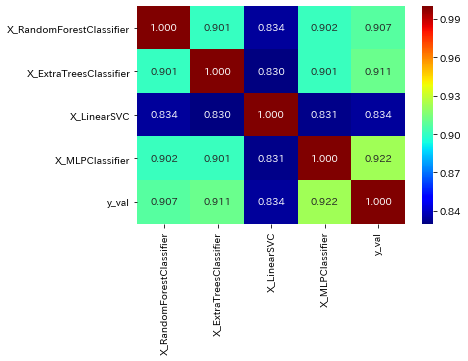

In [20]:
# FYI: 予測結果の相関を調べる
sns.heatmap(data=df_new_val.corr(),
            annot=True,
            fmt='.3f',
            cmap='jet')

## Blenderを訓練

In [21]:
# X_valをもとにしているので、正解はy_valのまま
rnd_forest_blender = RandomForestClassifier(n_estimators=200, 
                                            oob_score=True, 
                                            random_state=42)

rnd_forest_blender.fit(X_val_predictions, y_val);

In [22]:
# Baggingなので、約36%は使われないやーつ
rnd_forest_blender.oob_score_

0.9293333333333333

## テストセットでの評価
- 手順に注意ね

In [23]:
X_test_predictions = np.empty((len(X_test),
                               len(estimators)), 
                              dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

# 各列には、各予測器での予測結果(先ほどと同様)
X_test_predictions    

array([[6., 6., 6., 8.],
       [9., 9., 9., 9.],
       [5., 8., 3., 5.],
       ...,
       [4., 4., 4., 4.],
       [2., 2., 2., 2.],
       [5., 5., 6., 6.]], dtype=float32)

In [24]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [25]:
accuracy_score(y_test, y_pred)

0.9438